### E-commerce Analytics - PySpark MLlib

#### Set up

In [1]:
import pandas as pd
import os.path
import numpy as np

import pyspark
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SQLContext
from pyspark.mllib.clustering import KMeans, KMeansModel
#from pyspark.ml.clustering import KMeans

import matplotlib.pyplot as plt

In [2]:
## Start the spark session
conf = pyspark.SparkConf().setAll([('spark.app.name', 'PySpark Clustering')])
spark = SparkSession.builder.config(conf=conf).getOrCreate()

print (spark.version)
print (pyspark.version)

conf.getAll()

2.4.0
<module 'pyspark.version' from '/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pyspark/version.py'>


dict_items([('spark.app.name', 'PySpark Clustering')])

#### Load Data

In [3]:
customer_review = pd.read_csv('./ecommerce/customer_reviews_dataset.csv')
order_item = pd.read_csv('./ecommerce/order_items_dataset.csv')
orders = pd.read_csv('./ecommerce/orders_dataset.csv')
products = pd.read_csv('./ecommerce/products_dataset.csv')
product_name_translate = pd.read_csv('./ecommerce/product_category_name_translation.csv')

#### Merge Data

In [4]:
data = customer_review[['review_id','order_id','survey_score']].merge(order_item[['order_id','product_id']], how = 'left', on = 'order_id')
data = data.merge(orders[['order_id','customer_id']], how = 'left', on = 'order_id')
data = data.merge(products[['product_id', 'product_category_name']], how = 'left', on = 'product_id')
data = data.merge(product_name_translate, how = 'left', on = 'product_category_name')

#### Data Preparation

In [5]:
# Drop NAs
data = data.dropna(how='any')

In [6]:
# Get Avg Survey Score per category per customer
d1 = data[['customer_id', 'product_category_name_english', 'survey_score']]
#d1 = d1.groupby(by = ['customer_id', 'product_category_name_english']).mean()
#d1 = d1.reset_index()
d1 = d1.rename(index=str, columns={"product_category_name_english": "category"})
d1 = d1.groupby(['customer_id','category'])['survey_score'].mean().unstack(fill_value=0)
d1 = d1.reset_index()

In [7]:
# Get total purchases per customer per category
d2 = data[['customer_id', 'product_category_name_english']]
d2 = d2.groupby(by = ['customer_id', 'product_category_name_english']).size().reset_index(name='counts')
d2 = d2.rename(index=str, columns={"product_category_name_english": "category"})
d2 = d2.groupby(['customer_id','category'])['counts'].sum().unstack(fill_value=0)
d2 = d2.reset_index()

In [8]:
# Merge d1 and d2
data = d1.merge(d2, how = 'left', on ='customer_id', suffixes=('_rate','_count'))

In [9]:
# Split into Train and Test (0.8,0.2)
train_data_unscaled, test_data_unscaled = np.split(data.sample(frac=1, 
                                                   random_state=1729), 
                                                   [int(0.8 * len(data))])

print ("Train and test data sizes")
print (train_data_unscaled.shape, test_data_unscaled.shape)

Train and test data sizes
(77804, 143) (19452, 143)


In [11]:
# Get feature column names
featureCols = list(data.columns)[1:]

In [12]:
vecAssembler = VectorAssembler(inputCols= featureCols, outputCol="features")

In [13]:
#sc = SparkContext(conf=conf)
sqlCtx = SQLContext(spark)
data_pyspark = sqlCtx.createDataFrame(data)

In [14]:
output = vecAssembler.transform(data_pyspark)

In [16]:
output.toPandas()

,customer_id,agro_industry_and_commerce_rate,air_conditioning_rate,art_rate,arts_and_craftmanship_rate,audio_rate,auto_rate,baby_rate,bed_bath_table_rate,books_general_interest_rate,...,signaling_and_security_count,small_appliances_count,small_appliances_home_oven_and_coffee_count,sports_leisure_count,stationery_count,tablets_printing_image_count,telephony_count,toys_count,watches_gifts_count,features
0,00012a2ce6f8dcda20d059ce98491703,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,000161a058600d5901f007fab4c27140,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,0001fd6190edaaf884bcaf3d49edf079,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.0, 0.0, 0.0, ..."
3,0002414f95344307404f0ace7a26f1d5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,000379cdec625522490c315e70c7a9fb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,...,0,0,0,0,0,0,0,0,0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.0, 0.0, ..."
5,0004164d20a9e969af783496f3408652,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,000419c5494106c306a97b5635748086,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,00046a560d407e99b969756e0b10f282,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,00050bf6e01e69d5c0fd612f1bcfb69c,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9,000598caf2ef4117407665ac33275130,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [15]:
rdd = output.select('features').rdd.map(tuple)

#### Determine the optimal K

In [19]:
cost = np.zeros(100)
for k in range(2,100):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = kmeans.fit(output.select('features').sample(False,0.1, seed=42))
    cost[k] = model.computeCost(output.select('features'))

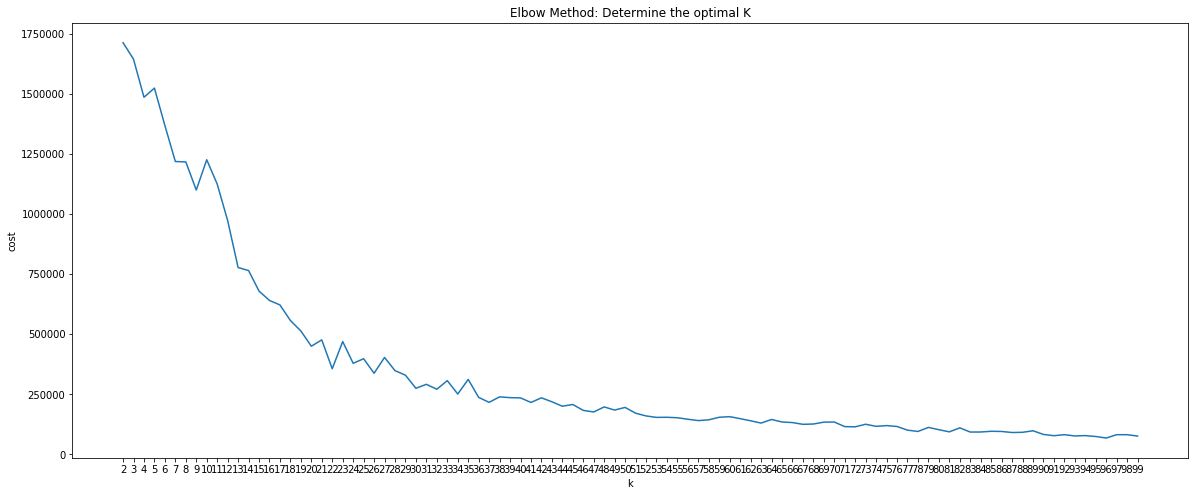

In [20]:
fig, ax = plt.subplots(1,1, figsize =(20,8))
ax.plot(range(2,100),cost[2:100])
ax.set_xticks(range(2, 100, 1))
ax.set_xlabel('k')
ax.set_ylabel('cost')
plt.title('Elbow Method: Determine the optimal K')
plt.show()

#### Modeling & Predict

In [18]:
clusters = KMeans.train(rdd, 20, maxIterations=10, initializationMode="random")

In [25]:
df = output.toPandas()
df['Prediction'] = df['features'].apply(lambda x:clusters.predict(pyspark.mllib.linalg.DenseVector(x)))

In [26]:
result = df[['customer_id', 'Prediction']]
result.to_csv('result.csv')

In [4]:
result = pd.read_csv('result.csv')

In [ ]:
## merge
dat = customer_review[['review_id','order_id','survey_score']].merge(order_item[['order_id','product_id']], how = 'left', on = 'order_id')
dat = dat.merge(orders[['order_id','customer_id']], how = 'left', on = 'order_id')
dat = dat.merge(products[['product_id', 'product_category_name']], how = 'left', on = 'product_id')
dat = dat.merge(product_name_translate, how = 'left', on = 'product_category_name')

#### Analyze

In [7]:
dat = dat.merge(result, how = 'left', on = 'customer_id')

In [8]:
dat = dat.rename(index = str, columns = {'product_category_name_english': 'category'})

In [3]:
#dat.to_csv('dat.csv')
dat = pd.read_csv('dat.csv')

In [ ]:
res = dat.groupby(by = ['Prediction', 'category']).size().reset_index()

In [38]:
#res.to_csv('res.csv')

In [34]:
cluster_01 = res[res['Prediction'] == 0.0]

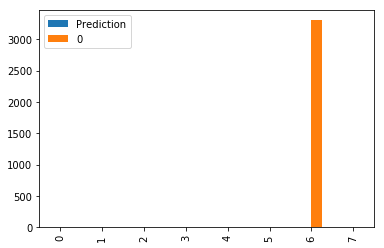

In [37]:
cluster_01.plot(kind='bar')

In [ ]:
count = 1
plt.figure(figsize=(20,20))
for name, group in dat.groupby(by = ['Prediction']):
    #print(name)
    plt.subplot(4,4,count)
    count += 1
    group['category'].hist()
    plt.show()
    break

In [4]:
## merge zipcode
customers = pd.read_csv('./ecommerce/customers_dataset.csv')
geo = pd.read_csv('./ecommerce/geolocation_dataset.csv')

In [5]:
dat = dat.merge(customers[['customer_id', 'customer_zip_code_prefix']], how = 'left', on = 'customer_id')

In [6]:
dat = dat.merge(geo[['geo_zip_code_prefix', 'geo_lat', 'geo_lng']], how = 'left', left_on = 'customer_zip_code_prefix', right_on = 'geo_zip_code_prefix')

In [10]:
#dat.to_csv('data.csv')

In [4]:
res = pd.read_csv('res.csv')

In [12]:
res[res['Prediction'] == 18.0]

,Unnamed: 0,Prediction,category,0
281,281,18.0,audio,3
282,282,18.0,computers_accessories,1
283,283,18.0,construction_tools_construction,1
284,284,18.0,electronics,1
285,285,18.0,furniture_decor,5
286,286,18.0,housewares,1
287,287,18.0,musical_instruments,1
288,288,18.0,stationery,1
289,289,18.0,toys,1
290,290,18.0,watches_gifts,5052
